# Image Quality Assessment

###### Oleh : Nur Asiah 0102514015


Keterangan eksplorasi 

Dataset yang dipakai adalah data gambar dari toko online OLX Indonesia yan sudah diberi label [`good`, `bad`].

Gambar memiliki channel RGB dengan ukuran pixel yang sama yaitu 200 X 300


In [2]:
from __future__ import print_function
from collections import Counter
from scipy.stats import norm
from scipy import misc

import glob
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import caffe

sys.path.insert(0,'./caffe/python')
sns.set(style="darkgrid", context="talk", palette="Set3")
RANDOM_STATE = 2401
np.random.seed(RANDOM_STATE)

%matplotlib inline

## Eksplorasi data

Jalankan cell di bawah hanya jika tidak memiliki file numpy.

In [3]:
X = []
y = []

for kelas in ['good', 'bad']:
    for img in glob.glob('dataset/'+ kelas +'/*'):
        y += [kelas]
        image = cv2.imread(img)
        X += [np.array(image)]

#X = np.asarray(X)
#y = np.asarray(y)

In [4]:
np.save('images.npy', X)
np.save('labels.npy', y)

Load images

In [3]:
X = np.load('images.npy')
y = np.load('labels.npy') 

In [3]:
images_good = X[y == 'good']
label_good = y[y == 'good']
images_bad = X[y == 'bad' ]
label_bad = y[y == 'bad']

Size of dataset

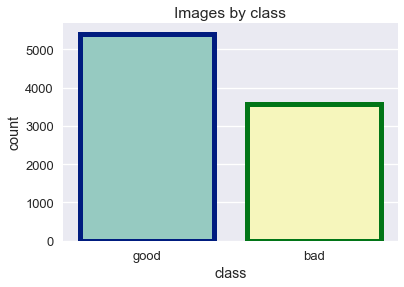

In [5]:
sns.countplot(y, linewidth=5, edgecolor=sns.color_palette("dark", 3))
plt.title('Images by class')
plt.xlabel('class')
plt.show()

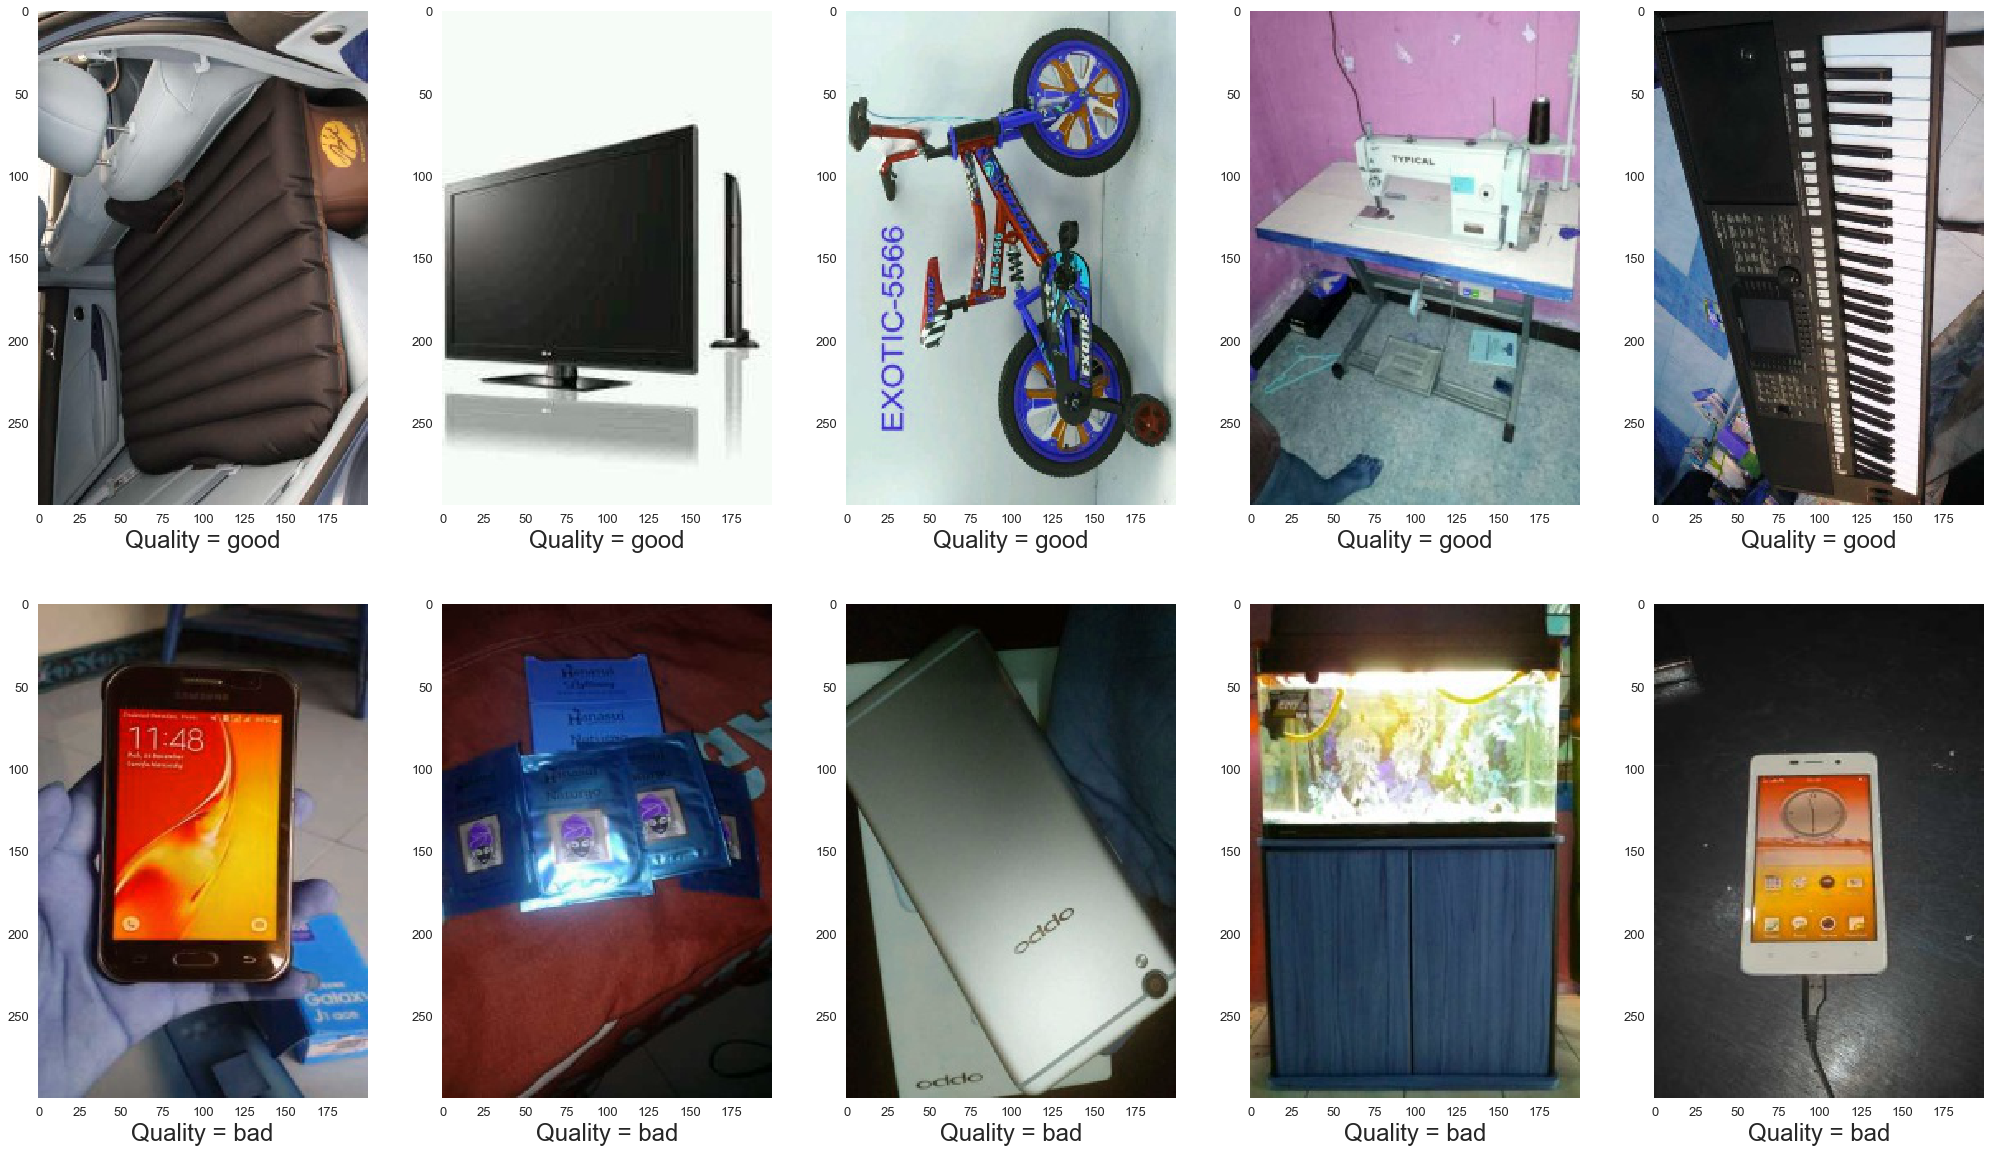

In [21]:
fig = plt.figure(figsize=(35,20))
count = 1
for kelas in ['good', 'bad']:
    for i in range(5):
        fig.add_subplot(2,5,count)
        rand = np.random.randint(0, locals()["images_"+str(kelas)].shape[0])
        plt.imshow(locals()["images_"+str(kelas)][rand], cmap = None)
        count += 1
        plt.grid(False)
        plt.xlabel('Quality = ' + str(locals()["label_"+str(kelas)][rand]), fontsize=24)
plt.show()

#### Histogram of Image

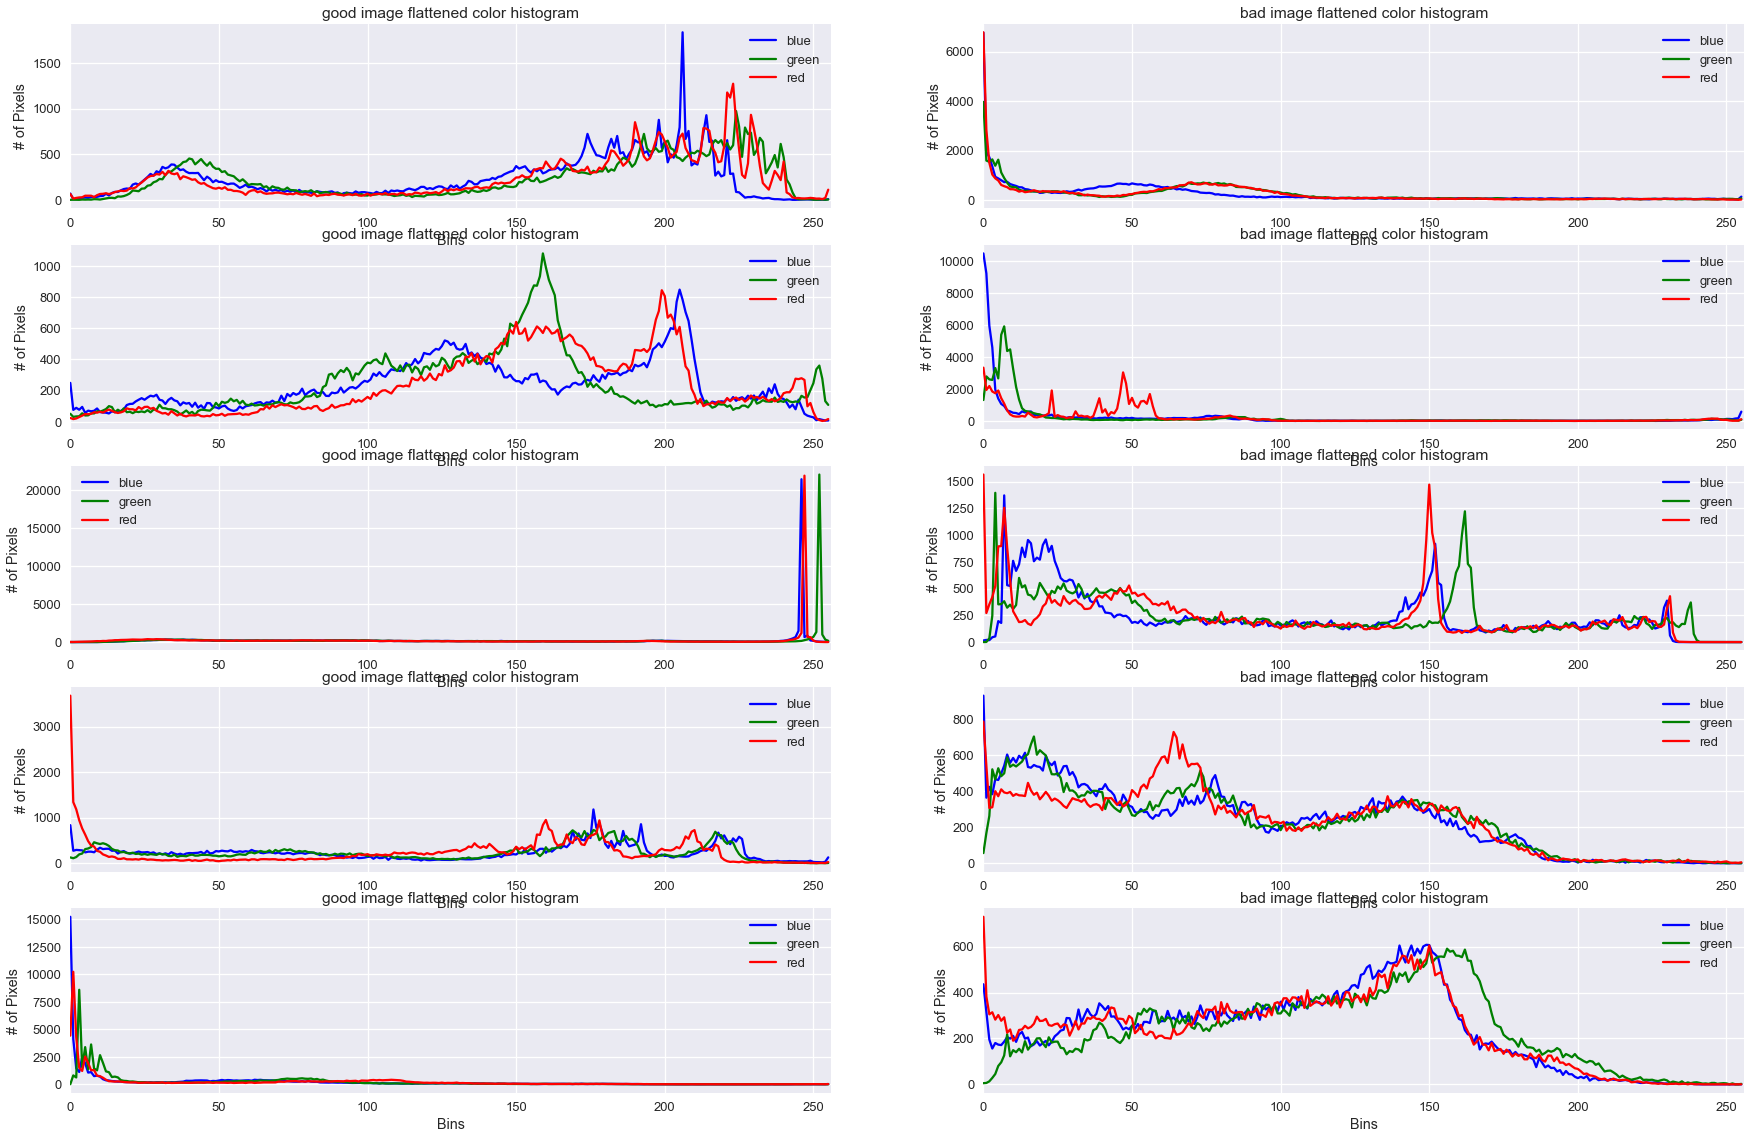

In [13]:
fig = plt.figure(figsize=(30,40))
count = 1
for i in range(5):
    for kelas in ['good', 'bad']:
        fig.add_subplot(10,2,count)
        plt.title(kelas + " image flattened color histogram")
        plt.xlabel("Bins")
        plt.ylabel("# of Pixels")
        features = []
        
        rand = np.random.randint(0, locals()["images_"+str(kelas)].shape[0])
        chans = cv2.split(locals()["images_"+str(kelas)][rand])
        colors = ("blue", "green", "red")
        for (chan, color) in zip(chans, colors):
            hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
            features.extend(hist)

            plt.plot(hist, color = color, label=color)
            plt.xlim([0, 256])

        count += 1
        plt.legend(loc='best')
plt.show()
   

Histogram dari kelas `good` dan `bad` tidak cukup terlihat berbeda.

#### Feature extraction

In [137]:
def sobel_edgedetect (channel):
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)

    sobel[sobel > 255] = 255
    return sobel

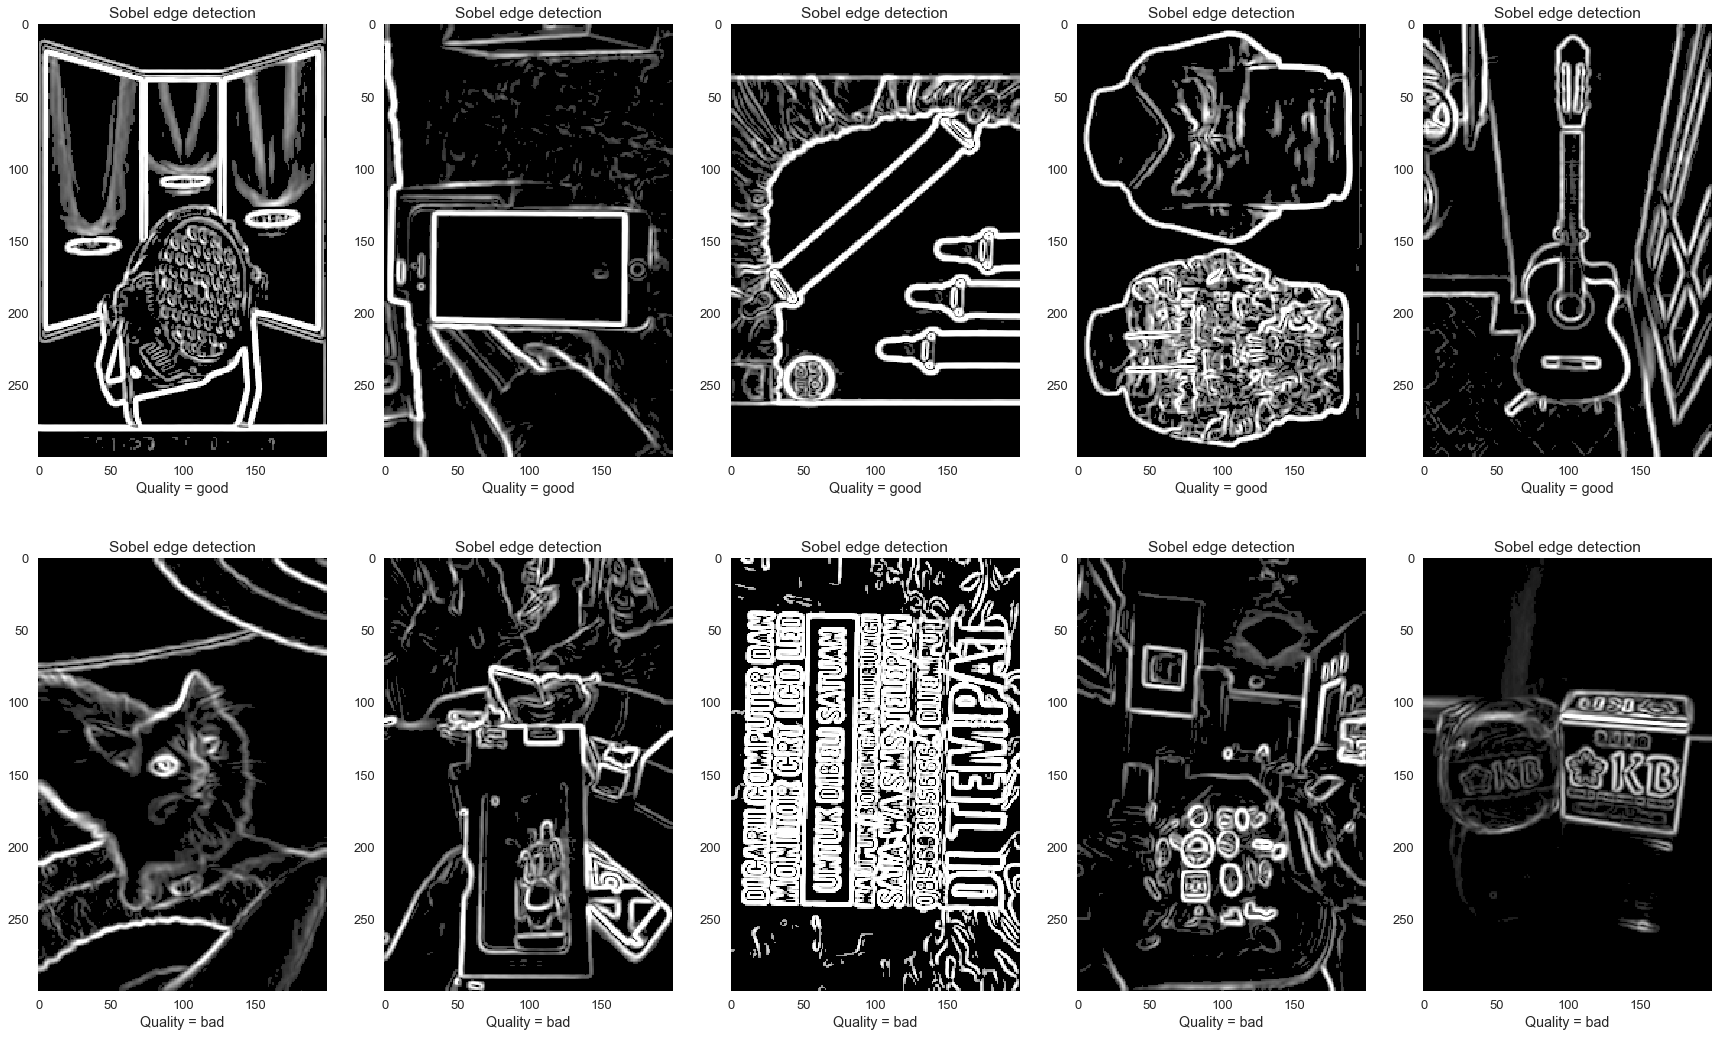

In [151]:
fig = plt.figure(figsize=(30,18))
count = 1
for kelas in ['good', 'bad']:
    for i in range(5):    
        fig.add_subplot(2,5,count)
        
        rand = np.random.randint(0, locals()["images_"+str(kelas)].shape[0])
        blurred = cv2.GaussianBlur(locals()["images_"+str(kelas)][rand], (5, 5), 0) # Remove noise
        edgeImg = np.max(np.array([edgedetect(blurred[:,:, 0]), 
                                   edgedetect(blurred[:,:, 1]), 
                                   edgedetect(blurred[:,:, 2]) ]), axis=0)
        mean = np.mean(edgeImg);
        edgeImg[edgeImg <= mean] = 0
        plt.imshow(edgeImg, cmap='gray')
        plt.grid(False)
        plt.title('Sobel edge detection')
        plt.xlabel('Quality = ' + kelas)
        
        count += 1

#### Salient-Object Detection

Menggunakan model dari [  ]

In [4]:
def initNet(root_path='./model',device_no=0):
    MODEL_FILE = root_path+'/deploy.prototxt'
    PRETRAINED = root_path+'/train_iter_40000.caffemodel'
    #if device_no>=0:
    #    caffe.set_device(device_no)
    #    caffe.set_mode_gpu()
    #else:
    caffe.set_mode_cpu()
    
    net = caffe.Classifier(MODEL_FILE, PRETRAINED,caffe.TEST)
    return net                       

#process only one image, one can modify it to process a batch of images
def processImage(net,filename):
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', np.array([ 104.00698793,  116.66876762,  122.67891434]))
    transformer.set_raw_scale('data', 255)  # images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  # channels in BGR order instead of RGB

    img=caffe.io.load_image(filename)
    (H,W,C)=img.shape   #C=3

    #process the image
    imgData=transformer.preprocess('data',img)
    net.blobs['data'].data[...] = imgData
    net.forward()

    outmap=net.blobs['outmap'].data[0,0,:,:]
    map_final=cv2.resize(outmap,(W,H))
    map_final-=map_final.min()
    map_final/=map_final.max()
    map_final=np.ceil(map_final*255)
    return map_final

In [5]:
net=initNet('./model',0)

In [9]:
filename='./dataset/good/g1_00_422193554.jpg' # nanti inputannya diubah
salmap=processImage(net,filename)

/home/nasiahur/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [24]:
(thresh, im_bw) = cv2.threshold(salmap.astype(np.uint8), 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


In [29]:
c = X[0].copy()
for i in range(300):
    for j in range(200):
        if im_bw[i][j] == 0:
            for k in range(3):
                c[i][j][k] = 255

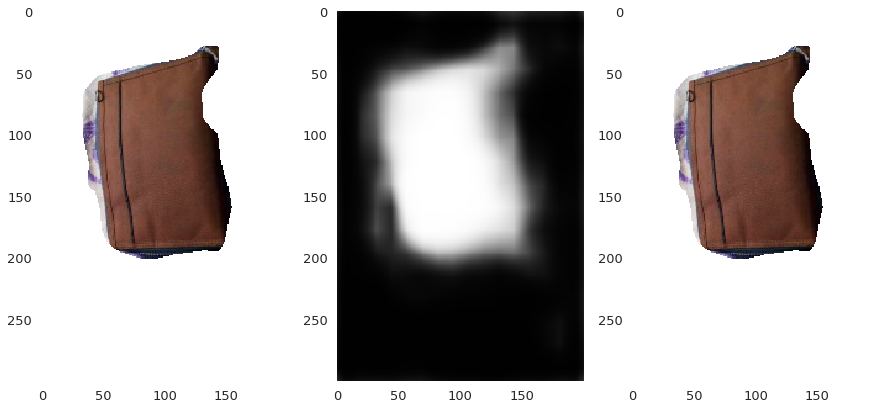

In [31]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1);plt.imshow(X[0])
plt.grid(False)
plt.subplot(1,3,2);plt.imshow(salmap,cmap='gray')
plt.grid(False)
plt.subplot(1,3,3);plt.imshow(c,cmap='gray')
plt.grid(False)